In [1]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

# Parameters
alpha = 4e-7
beta = -0.03
gamma = 0
N_0 = 40000

# Define s_dot function
def s_dot(s, delta):
    return alpha * s**2 + beta * s + gamma + delta / s

# Delta values to evaluate
delta_values = np.linspace(0.1, 800, 1000) * N_0
roots_positive = []
roots_negative = []

# Find roots for each delta
roots = np.zeros([1000,3])
for i, delta in enumerate(delta_values):
        roots[i] = np.roots([alpha, beta, gamma, delta])

print(roots)

[[ 74998.22213794    366.04271268   -364.26485061]
 [ 74983.98070068   1104.02743475  -1088.00813543]
 [ 74969.72843243   1521.68159847  -1491.4100309 ]
 ...
 [ 51430.15568009  51430.15568009 -27860.31136019]
 [ 51436.305844    51436.305844   -27872.61168801]
 [ 51442.45232458  51442.45232458 -27884.90464915]]


/tmp/ipykernel_64970/1840589270.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  roots[i] = np.roots([alpha, beta, gamma, delta])


<>:11: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_64970/2098390987.py:11: SyntaxWarning: invalid escape sequence '\g'
  ax1.set_xlabel('$\gamma$')
/tmp/ipykernel_64970/2098390987.py:12: SyntaxWarning: invalid escape sequence '\s'
  ax1.set_ylabel('$s^\star$')
/tmp/ipykernel_64970/2098390987.py:20: SyntaxWarning: invalid escape sequence '\d'
  ax2.set_xlabel('$\delta / N_0$')
/tmp/ipykernel_64970/2098390987.py:21: SyntaxWarning: invalid escape sequence '\s'
  ax2.set_ylabel('$s^\star$')
/tmp/ipykernel_64970/2098390987.py:6: RuntimeWarning: invalid value encountered in sqrt
  s_1 = -beta / (2 * alpha) * (1 + np.sqrt(1 - 4

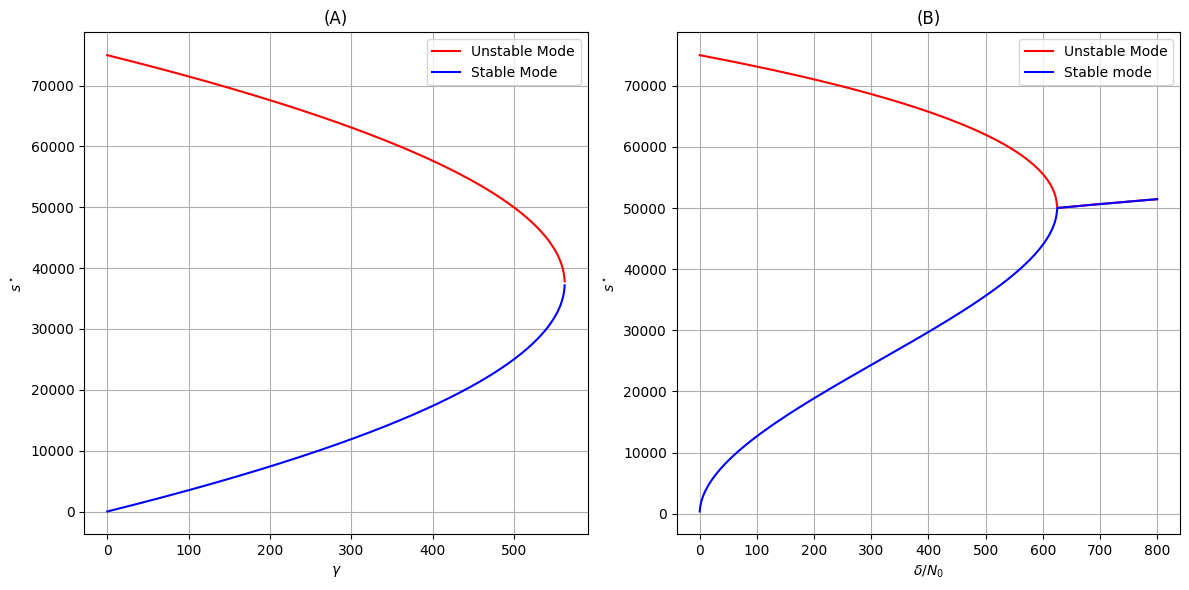

In [2]:
# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Gamma values and roots
gamma_values = np.linspace(0, 800, 10000)
s_1 = -beta / (2 * alpha) * (1 + np.sqrt(1 - 4 * gamma_values * alpha / beta**2))
s_2 = -beta / (2 * alpha) * (1 - np.sqrt(1 - 4 * gamma_values * alpha / beta**2))
ax1.plot(gamma_values, s_1, 'r', label='Unstable Mode')
ax1.plot(gamma_values, s_2, 'b', label='Stable Mode')
ax1.set_title('(A)')
ax1.set_xlabel('$\gamma$')
ax1.set_ylabel('$s^\star$')
ax1.legend()
ax1.grid('on')

# Delta vs Roots
ax2.plot(delta_values / N_0, roots[:,0], 'r', label='Unstable Mode')
ax2.plot(delta_values / N_0, roots[:,1], 'b', label='Stable mode')
ax2.set_title('(B)')
ax2.set_xlabel('$\delta / N_0$')
ax2.set_ylabel('$s^\star$')
ax2.legend()
ax2.grid('on')
plt.tight_layout()
plt.show()
fig.savefig('figure4.png')

In [3]:
N_total = 68301
N_average = N_total/65*10 #Fudged. the paper is missing factor of 10
#Define parametrs
alpha = 40/N_average**2
beta = 260/N_average
print(alpha, beta)
gamma = 0
delta = 0
N_0 = 40000

# Define s_dot function
def s_dot(t, s, beta, gamma, delta):
    return alpha * s**2 + beta * s + gamma + delta / s

def reach_sk(t, s):
    s_k = 1/alpha
    return s_k-s[0]

reach_sk.terminal = True

3.622701743303522e-07 0.024743415176937383


<>:47: SyntaxWarning: invalid escape sequence '\g'
<>:74: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\g'
<>:74: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_64970/3632696374.py:47: SyntaxWarning: invalid escape sequence '\g'
  ax1.plot(np.array(beta_vals) * N_0, t_values, label=f'$\gamma$ = {name}')
/tmp/ipykernel_64970/3632696374.py:74: SyntaxWarning: invalid escape sequence '\d'
  ax2.plot(np.array(beta_vals) * N_0, t_values, label=f'$\delta / N_0$ = {name}')
Processing delta values: 100%|████████████████████| 4/4 [00:20<00:00,  5.10s/it]


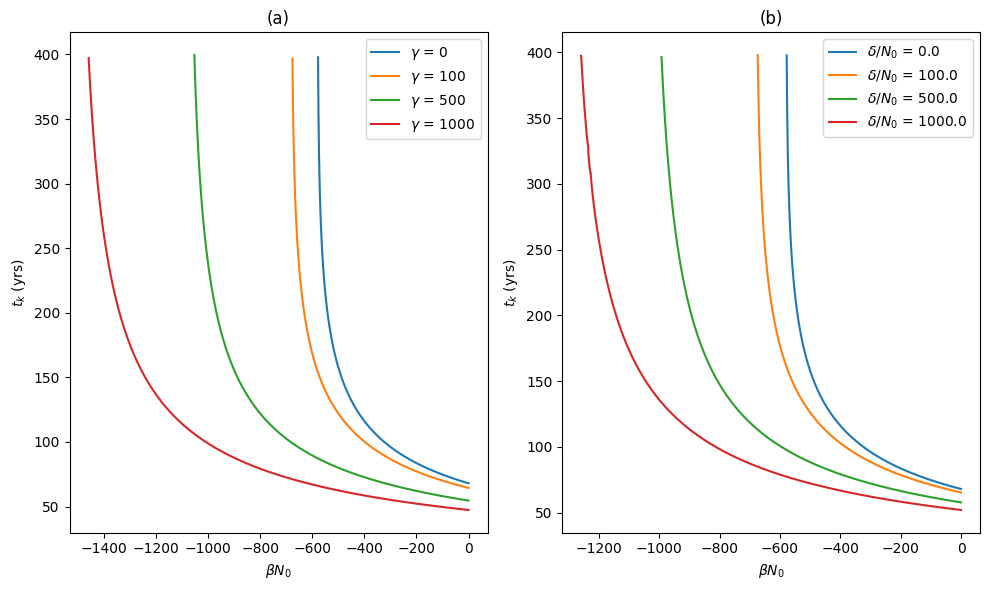

In [4]:
import numpy as np
from scipy.integrate import solve_ivp
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import matplotlib.pyplot as plt

# Assuming these variables and functions are defined elsewhere in your code
# N_0, s_dot, reach_sk

t_span = (0, 400)

beta_values = np.linspace(-1500, 0, 2000) / N_0  # Adjust the range and number as needed
delta_values = np.asarray([0, 100, 500, 1000])*N_0
gamma_values = [0, 100, 500, 1000]

# Function to solve ODE for a single (beta, gamma, delta) combination
def solve_single_case(beta, gamma, delta):
    sol = solve_ivp(
        fun=lambda t, s: s_dot(t, s, beta, gamma, delta),
        t_span=t_span,
        y0=[N_0],
        method='RK45',
        events=reach_sk
    )
    return sol.t[-1]  # Replace with `sol[-1, 0]` if needed

# Multithreading with progress tracking for the first graph
max_ts_gamma = {}
for gamma in tqdm(gamma_values, desc="Processing gamma values"):
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(solve_single_case, beta, gamma, 0): beta for beta in beta_values}
        t_betas = []
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Gamma = {gamma}", leave=False):
            beta = futures[future]  # Retrieve the associated beta value
            t_value = future.result()
            t_betas.append((beta, t_value))  # Store as tuple
    # Filter and sort by beta
    t_betas = [(beta, t_value) for beta, t_value in t_betas if t_value <= 399.9]
    t_betas.sort(key=lambda x: x[0])
    max_ts_gamma[f'{gamma}'] = t_betas

# Plotting the first graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
for name in max_ts_gamma:
    if max_ts_gamma[name]:  # Skip empty data
        beta_vals, t_values = zip(*max_ts_gamma[name])  # Unpack filtered and sorted tuples
        ax1.plot(np.array(beta_vals) * N_0, t_values, label=f'$\gamma$ = {name}')

ax1.set_xlabel(r"$\beta N_0$")
ax1.set_ylabel("$t_k$ (yrs)")
ax1.set_title("(a)")
ax1.legend()

# Multithreading with progress tracking for the second graph
max_ts_delta = {}
gamma = 0
for delta in tqdm(delta_values, desc="Processing delta values"):
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(solve_single_case, beta, gamma, delta): beta for beta in beta_values}
        t_betas = []
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Delta = {delta/N_0}", leave=False):
            beta = futures[future]  # Retrieve the associated beta value
            t_value = future.result()
            t_betas.append((beta, t_value))  # Store as tuple
    # Filter and sort by beta
    t_betas = [(beta, t_value) for beta, t_value in t_betas if t_value <= 399.9]
    t_betas.sort(key=lambda x: x[0])
    max_ts_delta[f'{delta/N_0}'] = t_betas

# Plotting the second graph
for name in max_ts_delta:
    if max_ts_delta[name]:  # Skip empty data
        beta_vals, t_values = zip(*max_ts_delta[name])  # Unpack filtered and sorted tuples
        ax2.plot(np.array(beta_vals) * N_0, t_values, label=f'$\delta / N_0$ = {name}')

ax2.set_xlabel(r"$\beta N_0$")
ax2.set_ylabel("$t_k$ (yrs)")
ax2.set_title("(b)")
ax2.legend()

plt.tight_layout()
plt.show()

In [5]:
fig.savefig('figure5.png')